# Restricted Boltzmann Machine (RBM)

This notebook demonstrates how to implement a Restricted Boltzmann Machine (RBM) using PyTorch to build a simple movie recommendation system. We use the **MovieLens 100K** dataset to model user preferences and recommend unseen movies based on learned interactions.

## Importing Libraries

In [1]:
# Data handling 
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch for building the RBM
import torch
import torch.nn as nn

# Additional Utilities
import random
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

## Data Loading and Exploration

In [2]:
# Load the dataset
# u.data from MovieLens 100K (tab-separated: user_id, item_id, rating, timestamp)
df = pd.read_csv('data/u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
df

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [3]:
# Basic info about datatypes and nulls
print("Dataset Info:")
df.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    100000 non-null  int64
 1   item_id    100000 non-null  int64
 2   rating     100000 non-null  int64
 3   timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


In [4]:
# Unique users and movies
n_users = df['user_id'].nunique()
n_items = df['item_id'].nunique()
print(f"Number of unique users: {n_users}")
print(f"Number of unique items (movies): {n_items}")

Number of unique users: 943
Number of unique items (movies): 1682


In [5]:
# Set style and color palette
sns.set(style='whitegrid', palette='pastel', font_scale=1.1)
plt.rcParams['figure.figsize'] = (8, 5)

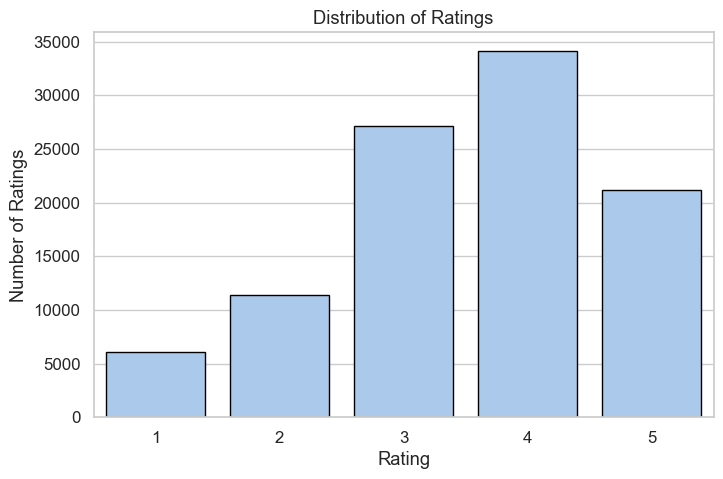

In [6]:
# Distribution of ratings
sns.countplot(data=df, x='rating', order=sorted(df['rating'].unique()), edgecolor='black')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Ratings')
plt.show()

We plotted how ratings are distributed across the dataset.

- Ratings **4 and 3 are the most frequent**, followed by 5.
- Very few ratings fall below 3, which suggests users are more likely to give positive feedback.

**This informed our decision to binarize ratings**, treating 4 and 5 as liked (1), and the rest as not liked (0). This simplifies the modeling and focuses on positive recommendations.

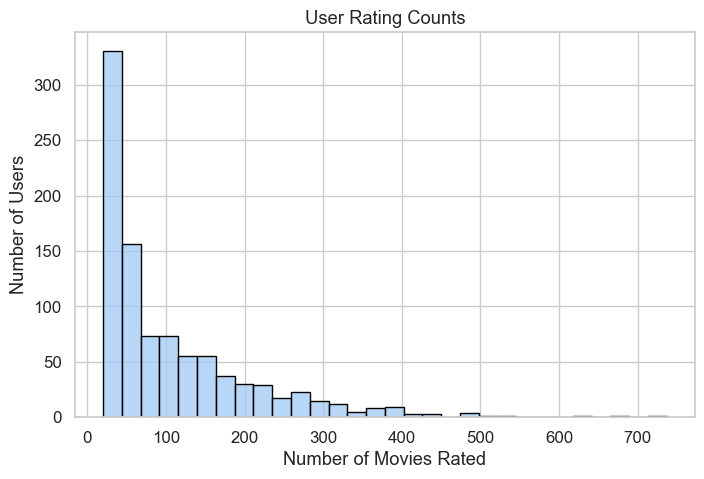

In [7]:
# User Activity
user_activity = df.groupby('user_id')['item_id'].count()
sns.histplot(user_activity, bins=30, edgecolor='black')
plt.title('User Rating Counts')
plt.xlabel('Number of Movies Rated')
plt.ylabel('Number of Users')
plt.show()

This plot shows how many movies each user has rated.

- Most users rated **very few movies** (fewer than 50).
- A small number of users are highly active, rating hundreds of movies.
- This creates a **long tail distribution** where many users contribute little data.
 
Sparse user profiles can make it harder for the model to learn preferences accurately. However, we will proceed without filtering for now and observe model performance. Later, we may consider removing extremely inactive users to improve learning.

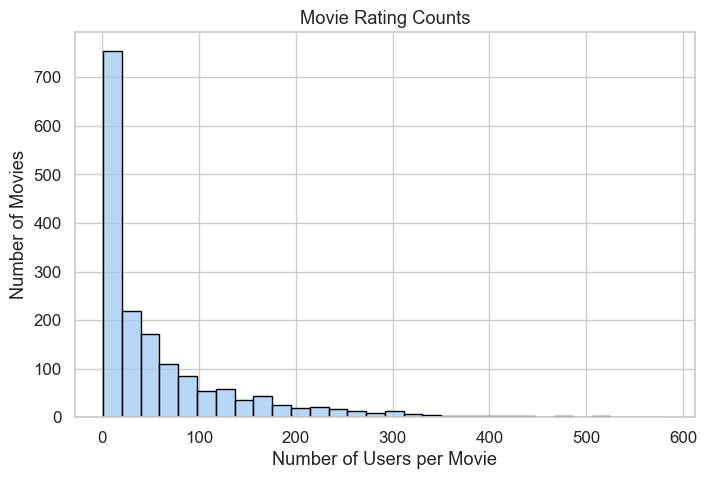

In [8]:
# Most Rated Movies
item_popularity = df.groupby('item_id')['user_id'].count()
sns.histplot(item_popularity, bins=30, edgecolor='black')
plt.title('Movie Rating Counts')
plt.xlabel('Number of Users per Movie')
plt.ylabel('Number of Movies')
plt.show()

This plot shows how often each movie was rated across users.

- A large number of movies are rated by **fewer than 20 users**.
- Only a few movies are rated by hundreds of users.
- The dataset is **movie-sparse**, making cold-start issues likely for lesser-known movies.
- The model will tend to favor popular movies due to richer training data.

We will continue with all movies included for now and evaluate the model's effectiveness. Later, we can test whether filtering out movies with too few ratings improves recommendations.

## Preprocessing

In [9]:
# Binarize ratings: 1 for 'liked' (4 or 5), 0 for others
df['binarized_rating'] = df['rating'].apply(lambda x: 1 if x >= 4 else 0)

# Create user-item matrix with binarized ratings
user_item_matrix = df.pivot(index='user_id', columns='item_id', values='binarized_rating')

# Fill missing values with -1 (indicates unrated)
user_item_matrix.fillna(-1, inplace=True)

# Store mappings for decoding
user_id_mapping = {idx: i for i, idx in enumerate(user_item_matrix.index)}
movie_id_mapping = {idx: i for i, idx in enumerate(user_item_matrix.columns)}

# Convert to PyTorch tensor
training_data = torch.FloatTensor(user_item_matrix.values)

# Clone training and test data to simulate hiding ratings for evaluation
train_data = training_data.clone()
test_data = training_data.clone()

# Mask a few ratings per user in train_data, retain them in test_data for evaluation
for user in range(training_data.shape[0]):
    rated_items = torch.where(training_data[user] != -1)[0]
    
    if len(rated_items) >= 10:
        test_items = random.sample(rated_items.tolist(), k=2)
        for item in test_items:
            train_data[user][item] = -1  # hide from training
    else:
        test_data[user] = -1  # not enough data for reliable testing

## RBM Model: Training and Evaluation

In [10]:
class RBM(nn.Module):
    def __init__(self, n_visible, n_hidden):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(n_hidden, n_visible) * 0.1)  # Weight matrix
        self.h_bias = nn.Parameter(torch.zeros(n_hidden))  # Hidden layer bias
        self.v_bias = nn.Parameter(torch.zeros(n_visible))  # Visible layer bias

    def sample_hidden(self, v):
        # Probabilities of hidden units
        h_prob = torch.sigmoid(torch.matmul(v, self.W.t()) + self.h_bias)
        return h_prob, torch.bernoulli(h_prob)

    def sample_visible(self, h):
        # Probabilities of visible units
        v_prob = torch.sigmoid(torch.matmul(h, self.W) + self.v_bias)
        return v_prob, torch.bernoulli(v_prob)

    def forward(self, v):
        # Gibbs sampling step: v -> h -> v
        h_prob, h_sample = self.sample_hidden(v)
        v_prob, v_sample = self.sample_visible(h_sample)
        return v_prob

In [11]:
def train_rbm(rbm, data, epochs, batch_size, lr):
    num_users = data.size(0)
    epoch_losses = []

    for epoch in range(epochs):
        epoch_loss = 0
        for i in range(0, num_users, batch_size):
            v0 = data[i:i+batch_size]
            vk = v0.clone()

            # Positive phase
            ph0, h0 = rbm.sample_hidden(v0)

            # Negative phase (1-step Gibbs sampling)
            _, hk = rbm.sample_hidden(vk)
            vk_prob, vk = rbm.sample_visible(hk)

            # Keep unrated items unchanged
            mask = v0 != -1
            vk[~mask] = v0[~mask]

            phk, _ = rbm.sample_hidden(vk)

            # Update weights and biases
            with torch.no_grad():
                rbm.W += lr * (torch.matmul(h0.t(), v0) - torch.matmul(phk.t(), vk)) / batch_size
                rbm.v_bias += lr * torch.sum(v0 - vk, dim=0) / batch_size
                rbm.h_bias += lr * torch.sum(ph0 - phk, dim=0) / batch_size

            # Compute reconstruction error only on rated items
            loss = torch.mean(torch.abs(v0[mask] - vk[mask]))
            epoch_loss += loss.item()

        avg_loss = epoch_loss / (num_users // batch_size)
        epoch_losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    # Plot training loss
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, epochs+1), epoch_losses, marker='o')
    plt.title("Training Reconstruction Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

Epoch 1/20, Loss: 0.5269
Epoch 2/20, Loss: 0.5018
Epoch 3/20, Loss: 0.4908
Epoch 4/20, Loss: 0.4871
Epoch 5/20, Loss: 0.4869
Epoch 6/20, Loss: 0.4857
Epoch 7/20, Loss: 0.4841
Epoch 8/20, Loss: 0.4823
Epoch 9/20, Loss: 0.4834
Epoch 10/20, Loss: 0.4805
Epoch 11/20, Loss: 0.4798
Epoch 12/20, Loss: 0.4803
Epoch 13/20, Loss: 0.4815
Epoch 14/20, Loss: 0.4804
Epoch 15/20, Loss: 0.4763
Epoch 16/20, Loss: 0.4763
Epoch 17/20, Loss: 0.4759
Epoch 18/20, Loss: 0.4767
Epoch 19/20, Loss: 0.4753
Epoch 20/20, Loss: 0.4807


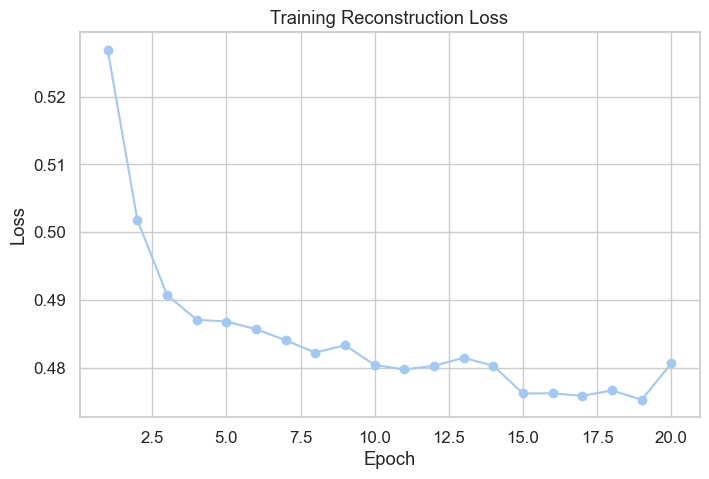

In [12]:
rbm = RBM(n_visible=training_data.shape[1], n_hidden=128)
epochs = 20
batch_size = 128
learning_rate = 0.1

# Train
train_rbm(rbm, training_data, epochs=epochs, batch_size=batch_size, lr=learning_rate)

In [13]:
def evaluate_rbm(rbm, test_data, threshold=0.5):
    y_true, y_pred, y_prob = [], [], []

    with torch.no_grad():
        for user in test_data:
            v = user.clone()
            mask = v != -1
            if torch.sum(mask) == 0:
                continue

            prob_v = rbm(v.unsqueeze(0)).squeeze()

            actual = v[mask].detach().numpy()
            predicted = (prob_v[mask].detach().numpy() >= threshold).astype(int)

            y_true.extend(actual)
            y_pred.extend(predicted)
            y_prob.extend(prob_v[mask].detach().numpy())

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, digits=3))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Recommended", "Recommended"], yticklabels=["Not Recommended", "Recommended"])
    plt.title("Confusion Matrix")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

    # ROC Curve
    auc = roc_auc_score(y_true, y_prob)
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
    plt.plot([0,1],[0,1],"--",color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

Classification Report:
              precision    recall  f1-score   support

         0.0      0.661     0.561     0.607     44625
         1.0      0.685     0.768     0.724     55375

    accuracy                          0.676    100000
   macro avg      0.673     0.665     0.665    100000
weighted avg      0.674     0.676     0.672    100000



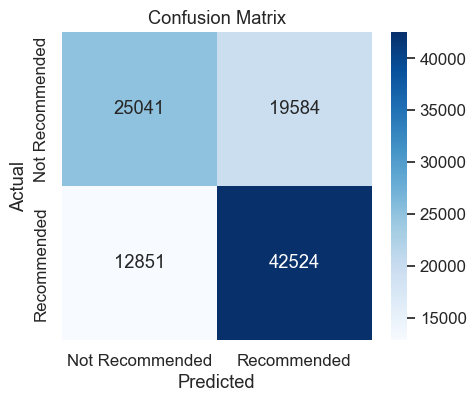

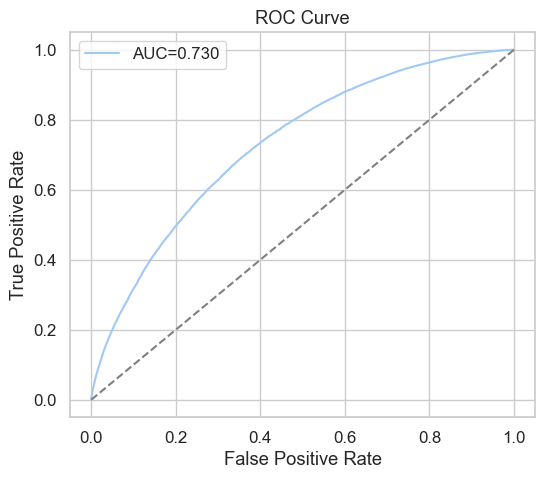

In [14]:
# Evaluate
evaluate_rbm(rbm, test_data)

## Conclusion

This notebook demonstrates the use of a Restricted Boltzmann Machine (RBM) for building a movie recommendation system on the MovieLens dataset.

- **Accuracy**: 67.6% on the test set
- **AUC**: 0.73, indicating a fair ability to distinguish between liked and disliked movies
- **Precision (Positive class)**: 68.5%, showing reasonable confidence when predicting movies users would like
- **Recall (Positive class)**: 76.8%, meaning the model captures most of the movies that users actually liked
- **Class Performance**: The model performs better at predicting positive ratings than negative ones, which makes it more effective for recommending movies rather than filtering out disliked ones

Overall, the RBM provides a solid baseline for recommendation tasks, successfully uncovering user–item interactions and setting the stage for more advanced deep learning approaches.